### Librairies

In [ ]:
import math
import time
import numpy as np 
from PIL import Image
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from phantominator import shepp_logan
from skimage.transform import radon, iradon
from skimage.color import rgb2gray

### Construction du sinogramme a partir de l'image

In [ ]:
phantom = shepp_logan(128) # chargement d'un fantôme de Shepp Logan de taille 128x128 
phantom = np.flipud(phantom)

ntheta = 100 # nombre d'angles pour la discrétisation
theta = np.linspace(0,180,ntheta)
sinogramme = radon(phantom, theta, circle = True) # sinogramme du fantôme de Shepp Logan

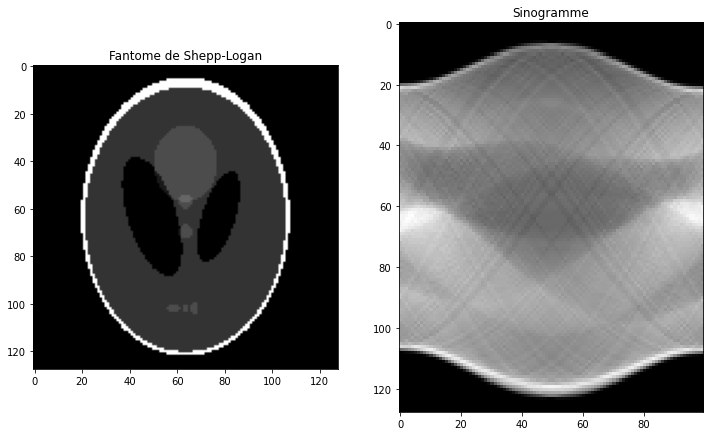

In [ ]:
# Affichage
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('Fantome de Shepp-Logan')
ax2.set_title('Sinogramme')
ax1.imshow(phantom, cmap='gray')
ax2.imshow(sinogramme, cmap = 'gray')

plt.show()

### Reconstruction de l'image a partir du sinogramme

In [ ]:
reconstruction = iradon(sinogramme, theta) # reconstruction par retroprojection filtrée du sinogramme

print('Valeur min de l image reconstruite = ', min(reconstruction.ravel()))
print('Valeur max de l image reconstruite = ', max(reconstruction.ravel()))

In [ ]:
# Projection des valeurs de l'image sur l'intervalle [0, 1]
reconstruction[reconstruction>1] = 1
reconstruction[reconstruction<0] = 0

min phantom =  -5.551115123125783e-17
max phantom =  1.0
min reconstruct =  0.0
max reconstruct =  1.0


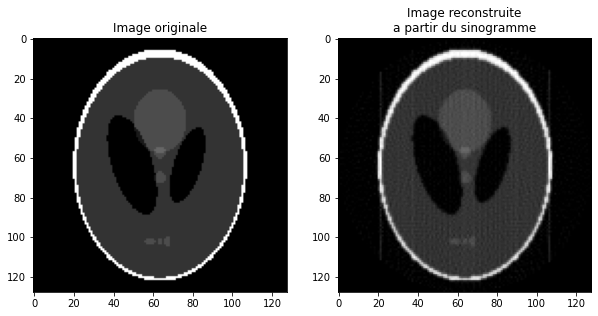

In [ ]:
# Affichage

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('Image originale')
ax2.set_title('Image reconstruite\na partir du sinogramme')
ax1.imshow(phantom, cmap='gray')
ax2.imshow(reconstruction, cmap = 'gray')

plt.show()

###  Données bruitées (bruit de Poisson)

In [ ]:
# Bruitage : on rajoute un bruit de Poisson au sinogramme pour simuler le bruit produit par le scanner lors des mesures de photons

n = sinogramme.shape[0]
m = sinogramme.shape[1]

sinogBruite = np.zeros(sinogramme.shape)
for i in range(n):
    for j in range(m):
        sinogBruite[i,j] = npr.poisson(sinogramme[i,j], size=1)

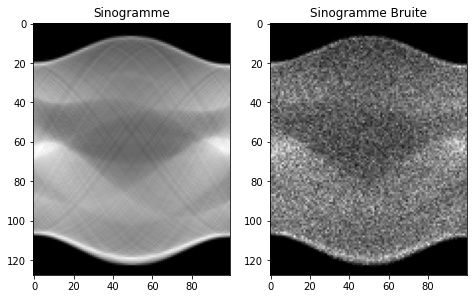

In [ ]:
# Affichage     

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

ax1.set_title('Sinogramme')
ax2.set_title('Sinogramme Bruité')
ax1.imshow(sinogramme, cmap='gray')
ax2.imshow(sinogBruite, cmap = 'gray')

plt.show()

### Reconstruction de l'image a partir des donnees bruitees 

In [ ]:
reconstructionBruit = iradon(sinogBruite, theta) # reconstruction de l'image à partir du sinogramme bruité

min reconstructBruit =  -0.939421890036237
max reconstructBruit =  1.6886871837190631


In [ ]:
# Projection des valeurs de l'image sur l'intervalle [0, 1]

reconstructionBruit[reconstructionBruit>1] = 1
reconstructionBruit[reconstructionBruit<0] = 0

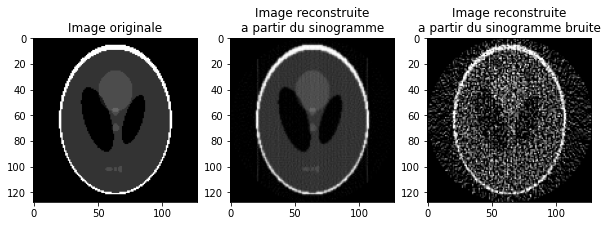

In [ ]:
# Affichage

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('Image originale')
ax2.set_title('Image reconstruite\na partir du sinogramme')
ax3.set_title('Image reconstruite\na partir du sinogramme bruite')
ax1.imshow(phantom, cmap='gray')
ax2.imshow(reconstruction, cmap = 'gray')
ax3.imshow(reconstructionBruit, cmap = 'gray')

plt.show()

## Richardson-Lucy

In [ ]:
# On calcule la matrice de la transformee de Radon (car on aura besoin de sa transposé)

n = phantom.shape[0]
E = np.zeros(n*n)
R = np.zeros((n*ntheta,n*n))

for i in range(n*n):
    E = np.zeros(n*n)
    E[i] = 1
    S = radon(E.reshape(n,n),theta).ravel()
    R[:,i] = S   

# On  sauvegarde la matrice de la transformée de radon pour eviter de la recalculer
np.save("radon.npy",R)

# On récupere la matrice de la transformée de radon si déjà calculée
# R = np.load("chemin/vers/le/fichier/.npy")

D:\Anaconda\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


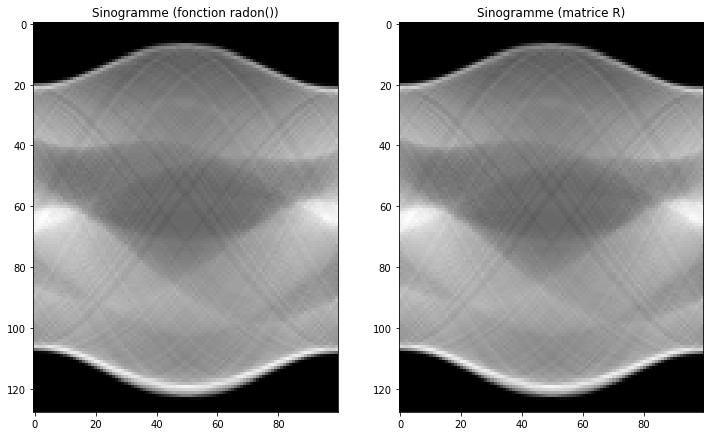

In [ ]:
# On verifie qu'on a bien le bon sinogramme quand on fait la multiplication matricielle de phantom par R
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_title('Sinogramme (fonction radon())')
ax2.set_title('Sinogramme (matrice R)')

ax1.imshow(sinogramme, cmap = 'gray')
ax2.imshow((R@phantom.ravel()).reshape((n,ntheta)), cmap = 'gray')

In [ ]:
# Création d'un vecteur constitué uniquement de 1. 
# Ce vecteur servira de point de départ pour l'algorithme de Richardson-Lucy de part sa stricte positivité

vect_unit = np.ones(R.T.shape[1])

In [ ]:
# Algorithme de Richardson-Lucy

def RL(b,tol,maxiter):
    image_estim_1 = np.ones(n*n)
    F = b.ravel()/(R @ image_estim_1)
    F[F!=F] = 0 #remplace par zero les nan dans F
    E = (R.T @ F)/(R.T @ vect_unit)
    image_estim_2 = np.multiply(E, image_estim_1)
    niter = 0
    
    while (any(image_estim_2/image_estim_1 > 1+tol) or any(image_estim_2/image_estim_1 < 1-tol))and niter<maxiter:
        image_estim_1 = np.copy(image_estim_2)
        F = b.ravel()/(R @ image_estim_2)
        F[F!=F] = 0 #remplace par zero les nan dans F
        E = (R.T @ F)/(R.T @ vect_unit)
        image_estim_2 = np.multiply(E, image_estim_2)
        niter=niter+1
        
    image_estim_2 = image_estim_2.reshape(n,n)
    return (image_estim_2,niter)

In [ ]:
# Exécution algorithme de Richardson-Lucy

tol = 10e-10 # niveau de tolérance du resultat
maxiter = 100 # nombre d'itération maximal

t_1 = time.time() # sert à calculer le temps d'exécution de l'algorithme
image_estim , niter = RL(sinogBruite, tol, maxiter)
t_2 = time.time()

<ipython-input-69-64c11497f66c>:4: RuntimeWarning: invalid value encountered in true_divide
  F = b.ravel()/(R @ image_estim_1)
<ipython-input-69-64c11497f66c>:12: RuntimeWarning: invalid value encountered in true_divide
  F = b.ravel()/(R @ image_estim_2)
<ipython-input-69-64c11497f66c>:10: RuntimeWarning: invalid value encountered in true_divide
  while (any(image_estim_2/image_estim_1 > 1+tol) or any(image_estim_2/image_estim_1 < 1-tol))and niter<100:
<ipython-input-69-64c11497f66c>:10: RuntimeWarning: invalid value encountered in greater
  while (any(image_estim_2/image_estim_1 > 1+tol) or any(image_estim_2/image_estim_1 < 1-tol))and niter<100:


In [ ]:
# Projection du résultat sur l'intervalle [0, 1]

image_estim[image_estim > 1] = 1

In [ ]:
print('Nombre d itérations:', niter)
print('Temps d exécution :', t_2-t_1)

nombre d iterations: 100
temps d execution : 36.14956021308899


## Affichage

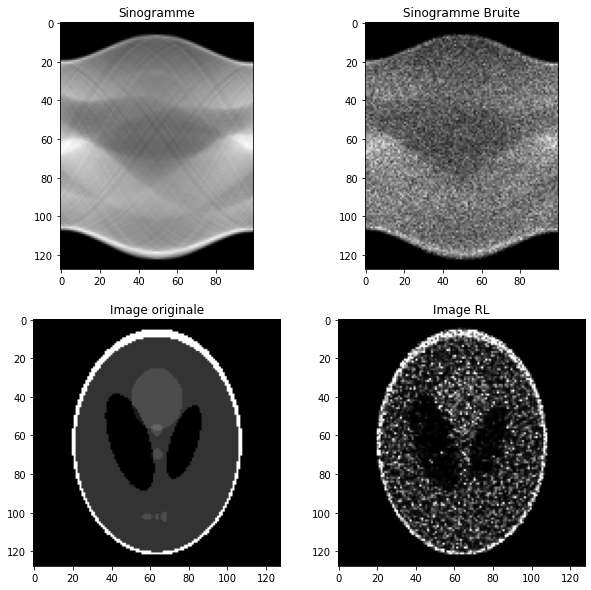

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.set_title('Sinogramme')
ax2.set_title('Sinogramme Bruite')
ax3.set_title('Image originale')
ax4.set_title('Image RL')

ax1.imshow(sinogramme, cmap ='gray')
ax2.imshow(sinogBruite, cmap = 'gray')
ax3.imshow(phantom, cmap = 'gray')
ax4.imshow(image_estim, cmap = 'gray')

plt.show()

## Coparaison : RPF vs RL

### Sinogramme sans bruit

In [ ]:
img_RL = RL(sinogramme,tol,maxiter)[0]

img_RL[img_RL > 1] = 1

<ipython-input-69-64c11497f66c>:4: RuntimeWarning: invalid value encountered in true_divide
  F = b.ravel()/(R @ image_estim_1)
<ipython-input-69-64c11497f66c>:12: RuntimeWarning: invalid value encountered in true_divide
  F = b.ravel()/(R @ image_estim_2)
<ipython-input-69-64c11497f66c>:10: RuntimeWarning: invalid value encountered in true_divide
  while (any(image_estim_2/image_estim_1 > 1+tol) or any(image_estim_2/image_estim_1 < 1-tol))and niter<100:
<ipython-input-69-64c11497f66c>:10: RuntimeWarning: invalid value encountered in greater
  while (any(image_estim_2/image_estim_1 > 1+tol) or any(image_estim_2/image_estim_1 < 1-tol))and niter<100:


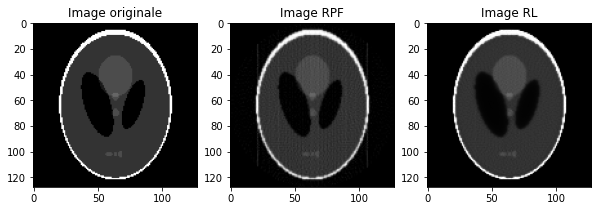

In [ ]:
# Affichage 

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('Image originale')
ax2.set_title('Image RPF')
ax3.set_title('Image RL')

ax1.imshow(phantom, cmap ='gray')
ax2.imshow(reconstruction, cmap = 'gray')
ax3.imshow(img_RL, cmap = 'gray')

### Sinogramme bruité

In [ ]:
img2_RL = RL(sinogBruite,tol,maxiter)[0]

img2_RL[img2_RL > 1] = 1

<ipython-input-69-64c11497f66c>:4: RuntimeWarning: invalid value encountered in true_divide
  F = b.ravel()/(R @ image_estim_1)
<ipython-input-69-64c11497f66c>:12: RuntimeWarning: invalid value encountered in true_divide
  F = b.ravel()/(R @ image_estim_2)
<ipython-input-69-64c11497f66c>:10: RuntimeWarning: invalid value encountered in true_divide
  while (any(image_estim_2/image_estim_1 > 1+tol) or any(image_estim_2/image_estim_1 < 1-tol))and niter<100:
<ipython-input-69-64c11497f66c>:10: RuntimeWarning: invalid value encountered in greater
  while (any(image_estim_2/image_estim_1 > 1+tol) or any(image_estim_2/image_estim_1 < 1-tol))and niter<100:


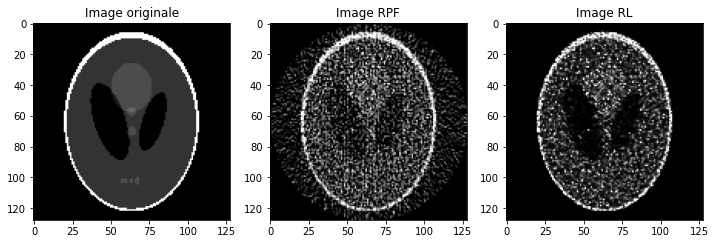

In [ ]:
# Affichage 

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('Image originale')
ax2.set_title('Image RPF')
ax3.set_title('Image RL')

ax1.imshow(phantom, cmap ='gray')
ax2.imshow(reconstructionBruit, cmap = 'gray')
ax3.imshow(img2_RL, cmap = 'gray')

## Influence du nombre d iterations dans l'algorithme de Richardson-Lucy

In [ ]:
# Test de l'algorithme avec plusieurs nombres d'itération maximaux 

maxiter1 = 100
maxiter2 = 200
maxiter3 = 500

img100 = RL(sinogBruite,tol,maxiter1)[0]
img200 = RL(sinogBruite,tol,maxiter2)[0]
img500 = RL(sinogBruite,tol,maxiter3)[0]

<ipython-input-82-b4dd5fc573fd>:4: RuntimeWarning: invalid value encountered in true_divide
  F = b.ravel()/(R @ image_estim_1)
<ipython-input-82-b4dd5fc573fd>:12: RuntimeWarning: invalid value encountered in true_divide
  F = b.ravel()/(R @ image_estim_2)
<ipython-input-82-b4dd5fc573fd>:10: RuntimeWarning: invalid value encountered in true_divide
  while (any(image_estim_2/image_estim_1 > 1+tol) or any(image_estim_2/image_estim_1 < 1-tol))and niter<maxiter:
<ipython-input-82-b4dd5fc573fd>:10: RuntimeWarning: invalid value encountered in greater
  while (any(image_estim_2/image_estim_1 > 1+tol) or any(image_estim_2/image_estim_1 < 1-tol))and niter<maxiter:


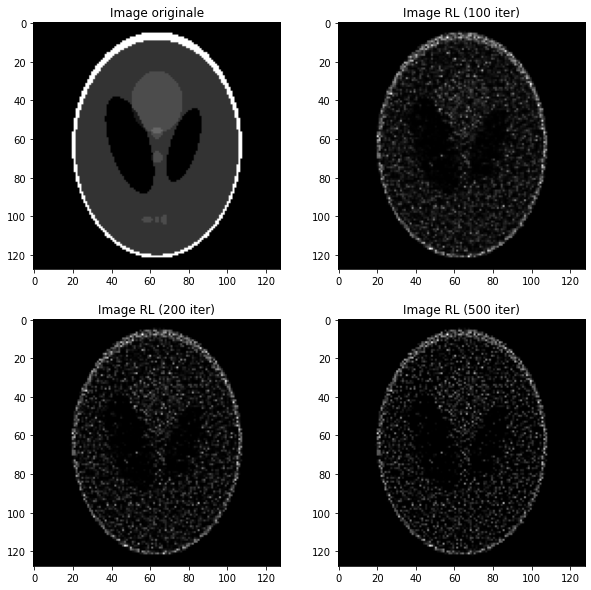

In [ ]:
# Affichage

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.set_title('Image originale')
ax2.set_title('Image RL (100 iter)')
ax3.set_title('Image RL (200 iter)')
ax4.set_title('Image RL (500 iter)')

ax1.imshow(phantom, cmap ='gray')
ax2.imshow(img100, cmap = 'gray')
ax3.imshow(img200, cmap = 'gray')
ax4.imshow(img500, cmap = 'gray')